In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from imshow import *
from IPython import display

In [69]:
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img, (512, 640))
  img = img[tf.newaxis, :]
  return img

In [70]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

style_path = 'style_img.jpg'

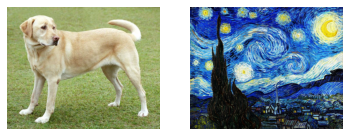

In [71]:
content_image = load_img(content_path)
style_image = load_img(style_path)

subplot_imshow([content_image, style_image], 1,2)

In [73]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [74]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [75]:
def vgg_layers(layer_names):
  """ 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
  # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [76]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv1
  크기:  (1, 512, 640, 64)
  최솟값:  0.0
  최댓값:  826.5079
  평균:  31.35748

block2_conv1
  크기:  (1, 256, 320, 128)
  최솟값:  0.0
  최댓값:  3855.9814
  평균:  192.49838

block3_conv1
  크기:  (1, 128, 160, 256)
  최솟값:  0.0
  최댓값:  8291.047
  평균:  197.60812

block4_conv1
  크기:  (1, 64, 80, 512)
  최솟값:  0.0
  최댓값:  19527.684
  평균:  710.35175

block5_conv1
  크기:  (1, 32, 40, 512)
  최솟값:  0.0
  최댓값:  4072.9326
  평균:  57.364906



In [77]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [78]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [79]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())

스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.0045270743
    최댓값:  28210.965
    평균:  250.31471

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  55319.305
    평균:  8460.46

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  492310.2
    평균:  6844.517

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  4165146.8
    평균:  121076.43

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  62724.477
    평균:  1084.0133

콘텐츠:
   block5_conv2
    크기:  (1, 32, 40, 512)
    최솟값:  0.0
    최댓값:  1938.384
    평균:  11.468492


In [80]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [83]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [84]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [105]:
style_weight=1e-1
content_weight= 1e5

In [109]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [117]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [114]:
image = tf.Variable(content_image)

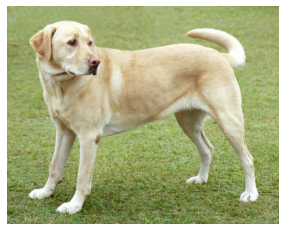

In [115]:
imshow(image)

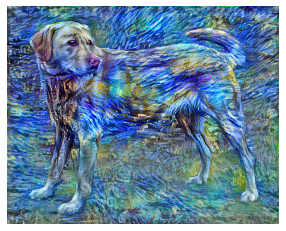

훈련 스텝: 1000
전체 소요 시간: 47.8


In [118]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image)
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))